In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [3]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

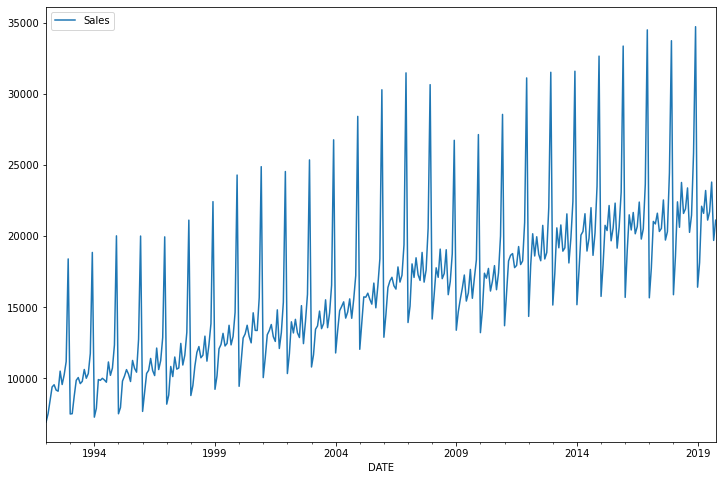

In [6]:
df.plot(figsize=(12,8))

In [7]:
len(df)

334

In [8]:
test_size = 18
test_ind = len(df) - test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler()

In [14]:
scaled_train = scaler.transform(train)

In [15]:
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
len(test)

18

In [28]:
# batch_size is predicted value of feature
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [29]:
X,y = generator[0]

In [30]:
y


array([[0.02047633]])

In [32]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [33]:
from tensorflow.keras.models import Sequential

In [34]:
from tensorflow.keras.layers import Dense,LSTM

In [36]:
n_features = 1 # we using only one feature of time series

In [38]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [42]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [43]:
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 36s 107ms/step - loss: 0.0254 - val_loss: 0.0223
Epoch 2/20
304/304 [==============================] - 30s 98ms/step - loss: 0.0178 - val_loss: 0.0021
Epoch 3/20
304/304 [==============================] - 30s 97ms/step - loss: 0.0113 - val_loss: 0.0015
Epoch 4/20
304/304 [==============================] - 30s 97ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 5/20
304/304 [==============================] - 30s 97ms/step - loss: 0.0037 - val_loss: 4.6710e-04
Epoch 6/20
304/304 [==============================] - 30s 97ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/20
304/304 [==============================] - 29s 97ms/step - loss: 0.0022 - val_loss: 2.4378e-04
Epoch 8/20
304/304 [==============================] - 30s 98ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/20
304/304 [==============================] - 30s 99ms/step - loss: 0.0012 - val_loss: 0.0038


In [44]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

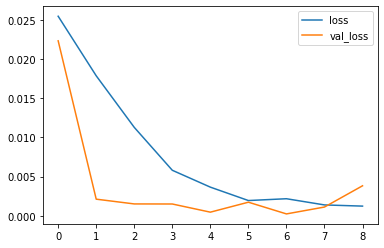

In [45]:
losses.plot()

In [48]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instance)
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update bathc to noe include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [49]:
true_prediction = scaler.inverse_transform(test_predictions)

In [50]:
test['Predictions'] = true_prediction

C:\Users\D4rkS\AppData\Local\Temp/ipykernel_1968/1596403840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_prediction


In [51]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,19640.629501
2018-06-01,21589,18564.659166
2018-07-01,21919,18816.043157
2018-08-01,23381,20583.108296
2018-09-01,20260,18105.393465
2018-10-01,21473,18698.035784
2018-11-01,25831,22582.678938
2018-12-01,34706,33438.153794
2019-01-01,16410,14150.754286


<AxesSubplot:xlabel='DATE'>

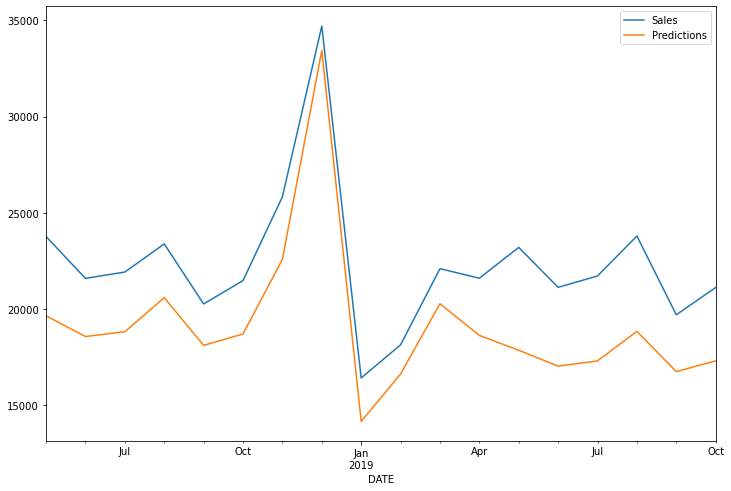

In [52]:
test.plot(figsize=(12,8))

In [54]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [56]:
length=12
generator=TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [58]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [59]:
model.fit(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 45s 134ms/step - loss: 0.0242
Epoch 2/8
322/322 [==============================] - 39s 122ms/step - loss: 0.0154
Epoch 3/8
322/322 [==============================] - 36s 111ms/step - loss: 0.0076
Epoch 4/8
322/322 [==============================] - 34s 105ms/step - loss: 0.0026
Epoch 5/8
322/322 [==============================] - 34s 106ms/step - loss: 0.0021
Epoch 6/8
322/322 [==============================] - 34s 106ms/step - loss: 0.0015
Epoch 7/8
322/322 [==============================] - 34s 106ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 35s 108ms/step - loss: 0.0015


In [60]:
forecast = []

periods=12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instance)
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update bathc to noe include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [61]:
forecast = scaler.inverse_transform(forecast)

In [62]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [63]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [64]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [65]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

<AxesSubplot:xlabel='DATE'>

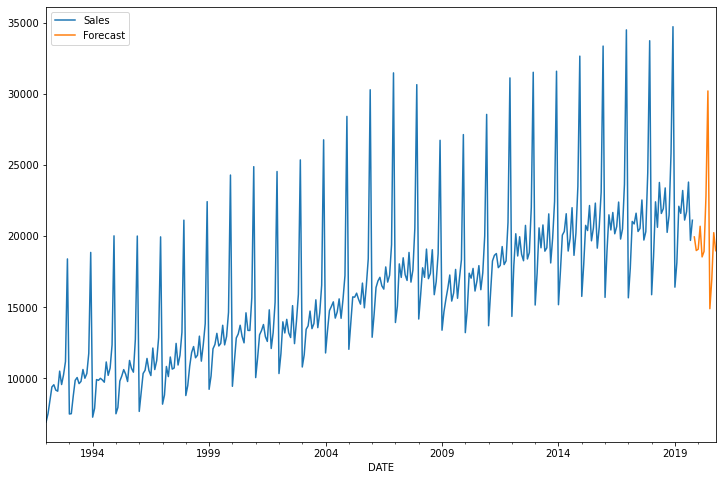

In [68]:

ax = df.plot()
forecast_df.plot(ax=ax,figsize=(12,8))